In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from IPython.display import Image, display

In [ ]:
import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("splcher/animefacedataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animefacedataset


In [3]:
import os

# Explore dataset path
print("Files in dataset directory:")
print(os.listdir(path))

Files in dataset directory:
['images']


In [ ]:
# --- Set the path to the images folder ---

image_path = os.path.join(path, "images")


In [5]:
image_path

'/kaggle/input/animefacedataset/images'

In [6]:
images_path = os.path.join(path, "images")
print("Contents of images folder:")
print(os.listdir(images_path)[:10])

Contents of images folder:
['35715_2011.jpg', '48610_2014.jpg', '34719_2011.jpg', '40266_2012.jpg', '4199_2002.jpg', '40739_2013.jpg', '42515_2013.jpg', '52482_2015.jpg', '46555_2014.jpg', '11579_2005.jpg']


In [7]:
import os
import shutil

# Original dataset directory from kagglehub
original_images_dir = os.path.join(path, "images")

# Destination in writable Colab path
destination_root = "/content/data/"
destination_class_dir = os.path.join(destination_root, "anime_faces")

os.makedirs(destination_class_dir, exist_ok=True)

# Copy images into dummy class folder
for file in os.listdir(original_images_dir):
    src = os.path.join(original_images_dir, file)
    dst = os.path.join(destination_class_dir, file)
    shutil.copy2(src, dst)

print("Copied images to:", destination_class_dir)


Copied images to: /content/data/anime_faces


In [ ]:
# --- Set up constants for training ---

DATA_DIR      = "/content/data/anime_faces"
IMAGE_SIZE    = 64
BATCH_SIZE    = 256
BUFFER_SIZE   = 60000
AUTOTUNE      = tf.data.AUTOTUNE

In [ ]:
# --- Create a TensorFlow dataset of image file paths ---

file_pattern = os.path.join(DATA_DIR, '*.jpg')
list_ds      = tf.data.Dataset.list_files(file_pattern, shuffle=True, seed=42)

In [ ]:
# --- (Optional) Check original image sizes ---

def get_original_size(path):
    img = tf.io.decode_jpeg(tf.io.read_file(path), channels=3)
    shape = tf.shape(img)[:2]
    return shape

sizes = [tuple(sz.numpy()) for sz in list_ds.map(get_original_size).batch(1000).take(1)][0]
heights, widths = zip(*sizes)


In [ ]:
# --- Image loading and preprocessing function ---

def load_and_preprocess(path):
    image = tf.io.decode_jpeg(tf.io.read_file(path), channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = (image - 127.5) / 127.5
    return image

In [ ]:
# --- Prepare the training dataset pipeline ---


train_dataset = (
    list_ds
    .map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(AUTOTUNE)
)

In [13]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(256, 64, 64, 3), dtype=tf.float32, name=None)>

In [ ]:
# --- Inspect a batch to confirm resizing ---


batch = next(iter(train_dataset))
resized_heights = batch.shape[1]
resized_widths  = batch.shape[2]
print(f"All images resized to: {resized_heights}×{resized_widths}")


All images resized to: 64×64


In [ ]:
# --- Define the Generator model ---

    # Dense layer to project and reshape input noise

def make_generator_model(latent_dim=100):
    model = tf.keras.Sequential(name="generator")
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((8, 8, 256)))
    # Upsample to 16x16

    model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    # Upsample to 32x32

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    # Upsample to 64x64 and output 3 channels (RGB)

    model.add(layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding="same", use_bias=False, activation="tanh"))

    return model

latent_dim = 100
generator = make_generator_model(latent_dim)
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16384)               │       1,638,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16384)               │          65,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 3)           │           4,800 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,733,504 (10.43 MB)

 Trainable params: 2,700,352 (10.30 MB)

 Non-trainable params: 33,152 (129.50 KB)

In [ ]:
# --- Define the Discriminator model ---


def make_discriminator_model():
    model = tf.keras.Sequential(name="discriminator")
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding="same", input_shape=[64,64,3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5,5), strides=(2,2), padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    # Flatten and output a single value (real/fake)

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          16,385 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,045,633 (3.99 MB)

 Trainable params: 1,045,633 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- Define loss functions for GAN training ---

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# --- Set up optimizers for both networks ---


generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

if __name__ == "__main__":
    noise = tf.random.normal([1, latent_dim])
    fake_img = generator(noise, training=False)
    disc_real = discriminator(tf.random.normal([1, 64, 64, 3]), training=False)
    disc_fake = discriminator(fake_img, training=False)
    print("Generator loss on dummy data:", generator_loss(disc_fake).numpy())
    print("Discriminator loss on dummy data:", discriminator_loss(disc_real, disc_fake).numpy())

Generator loss on dummy data: 0.6928387
Discriminator loss on dummy data: 1.3802838


In [ ]:
# --- Set up checkpointing for model saving ---

checkpoint_dir   = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint       = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)
manager          = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
# --- Prepare for saving generated images during training ---


num_examples_to_generate = 16
seed                     = tf.random.normal([num_examples_to_generate, latent_dim])

epoch_img_dir = './epoch_images'
os.makedirs(epoch_img_dir, exist_ok=True)

In [ ]:
# --- Training step for one batch ---

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output      = discriminator(images, training=True)
        fake_output      = discriminator(generated_images, training=True)
        gen_loss         = generator_loss(fake_output)
        disc_loss        = discriminator_loss(real_output, fake_output)

    grads_gen  = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grads_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grads_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grads_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
# --- Full training loop for multiple epochs ---

def train(dataset, epochs):
    for epoch in range(1, epochs + 1):
        start = time.time()
        gen_losses, disc_losses = [], []

        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            gen_losses.append(g_loss); disc_losses.append(d_loss)
        # Save model checkpoint every 5 epochs

        if epoch % 5 == 0:
            ckpt = manager.save()
            print(f"[Epoch {epoch}] Checkpoint saved: {ckpt}")
        # Generate and save sample images for this epoch

        fig = plt.figure(figsize=(4,4))
        preds = generator(seed, training=False)
        for i, img in enumerate(preds):
            plt.subplot(4,4,i+1)
            plt.imshow((img + 1)/2); plt.axis('off')
        plt.suptitle(f'Epoch {epoch}')

        fname = f"image_at_epoch_{epoch:03d}.png"
        path  = os.path.join(epoch_img_dir, fname)
        plt.savefig(path)
        plt.close(fig)
        # Display generated images in notebook

        display(Image(filename=path))
        # Print losses and timing

        print(
            f"Epoch {epoch} | "
            f"Gen loss: {tf.reduce_mean(gen_losses):.4f} | "
            f"Disc loss: {tf.reduce_mean(disc_losses):.4f} | "
            f"Time: {time.time()-start:.2f}s"
        )

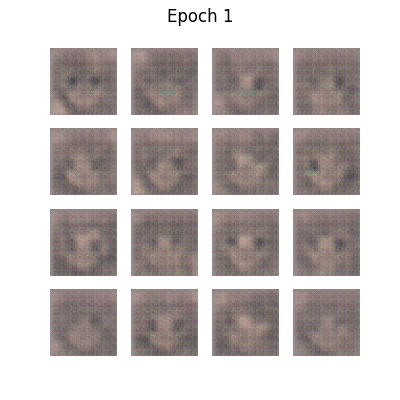

Epoch 1 | Gen loss: 1.5128 | Disc loss: 0.6826 | Time: 84.54s


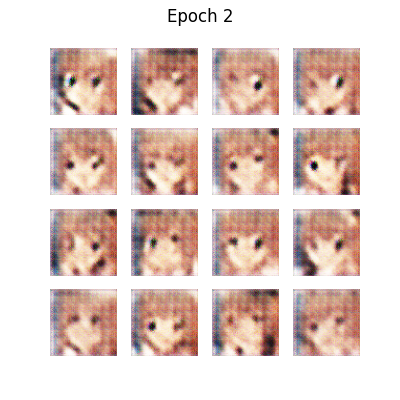

Epoch 2 | Gen loss: 1.1955 | Disc loss: 0.9659 | Time: 79.39s


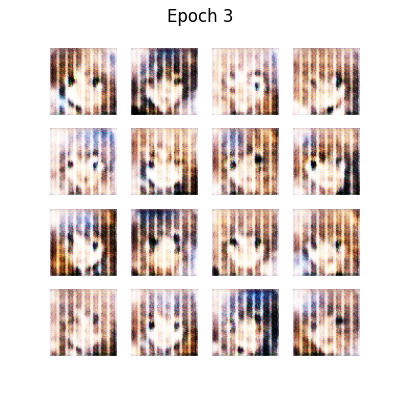

Epoch 3 | Gen loss: 0.9826 | Disc loss: 1.1239 | Time: 79.48s


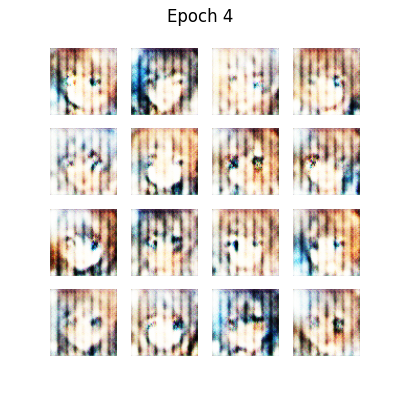

Epoch 4 | Gen loss: 1.0580 | Disc loss: 1.0424 | Time: 80.73s
[Epoch 5] Checkpoint saved: ./training_checkpoints/ckpt-1


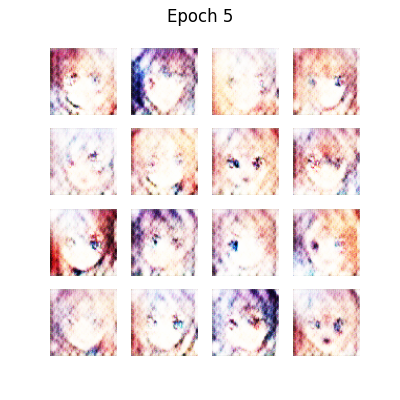

Epoch 5 | Gen loss: 1.1236 | Disc loss: 0.9862 | Time: 79.65s


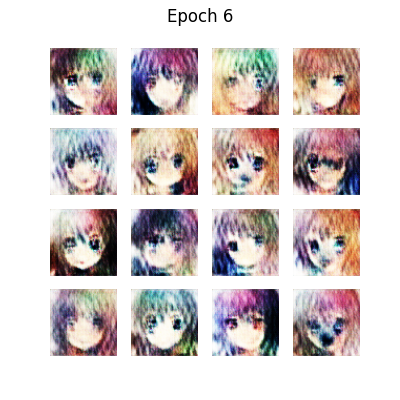

Epoch 6 | Gen loss: 1.0450 | Disc loss: 1.0514 | Time: 79.88s


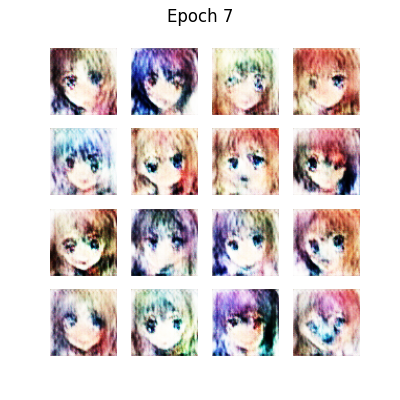

Epoch 7 | Gen loss: 0.9841 | Disc loss: 1.0885 | Time: 79.47s


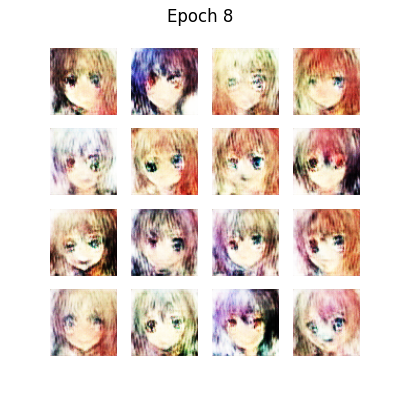

Epoch 8 | Gen loss: 0.9880 | Disc loss: 1.1007 | Time: 78.11s


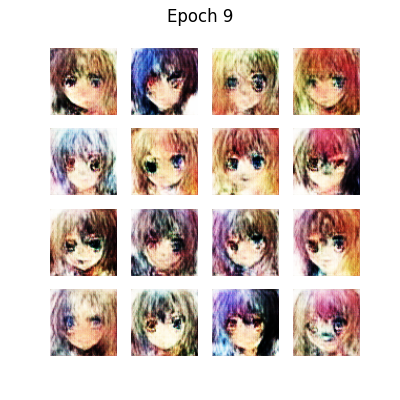

Epoch 9 | Gen loss: 0.9969 | Disc loss: 1.0932 | Time: 78.78s
[Epoch 10] Checkpoint saved: ./training_checkpoints/ckpt-2


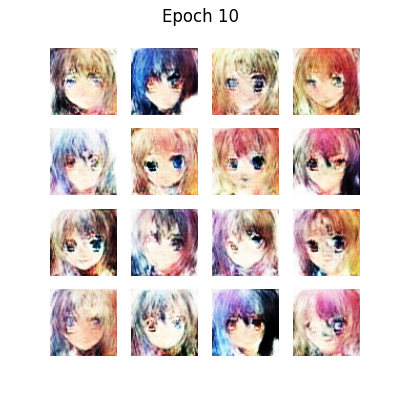

Epoch 10 | Gen loss: 1.0233 | Disc loss: 1.0657 | Time: 77.84s


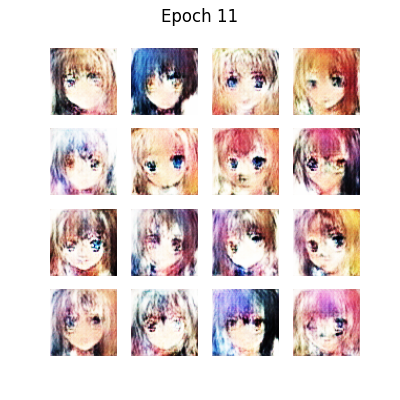

Epoch 11 | Gen loss: 1.0963 | Disc loss: 1.0033 | Time: 79.16s


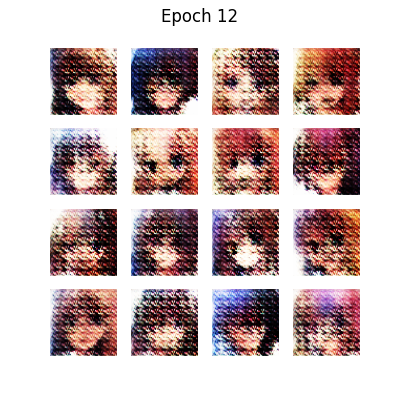

Epoch 12 | Gen loss: 1.2941 | Disc loss: 0.9206 | Time: 80.13s


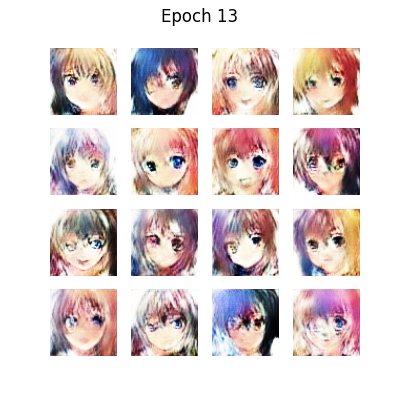

Epoch 13 | Gen loss: 1.4055 | Disc loss: 0.8819 | Time: 81.17s


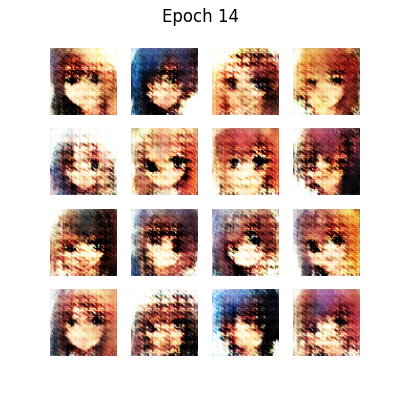

Epoch 14 | Gen loss: 1.6091 | Disc loss: 0.9134 | Time: 79.83s
[Epoch 15] Checkpoint saved: ./training_checkpoints/ckpt-3


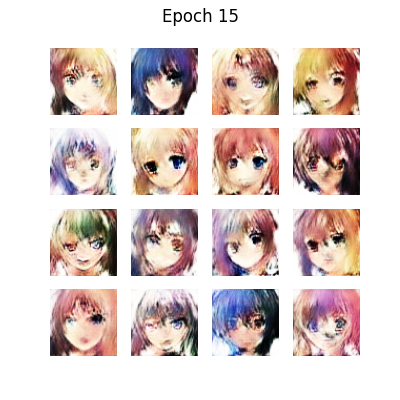

Epoch 15 | Gen loss: 1.1848 | Disc loss: 0.9406 | Time: 79.92s


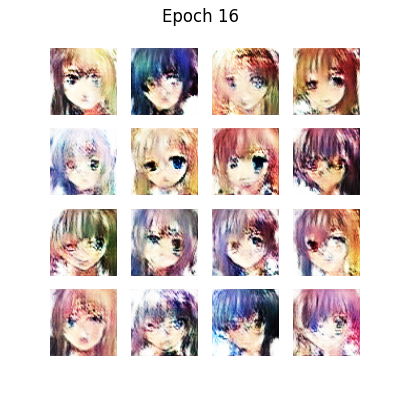

Epoch 16 | Gen loss: 1.2867 | Disc loss: 0.8726 | Time: 79.03s


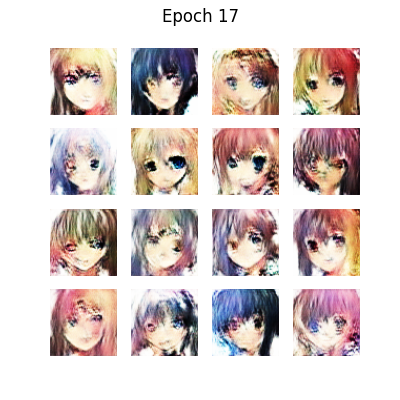

Epoch 17 | Gen loss: 1.2648 | Disc loss: 0.9245 | Time: 79.82s


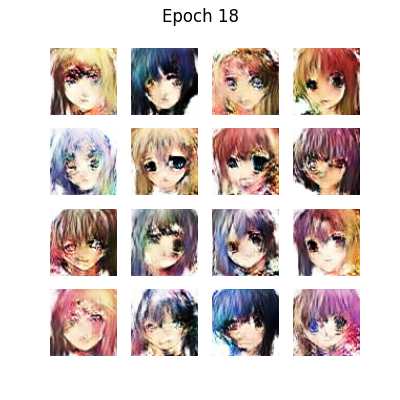

Epoch 18 | Gen loss: 1.2316 | Disc loss: 0.9451 | Time: 79.12s


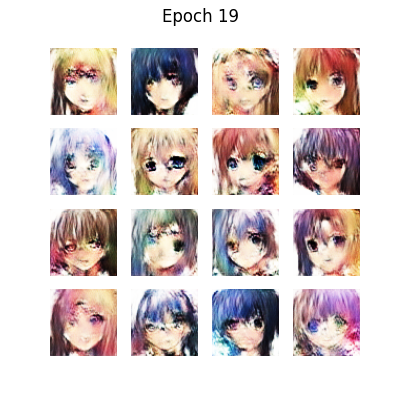

Epoch 19 | Gen loss: 1.2100 | Disc loss: 0.9571 | Time: 78.71s
[Epoch 20] Checkpoint saved: ./training_checkpoints/ckpt-4


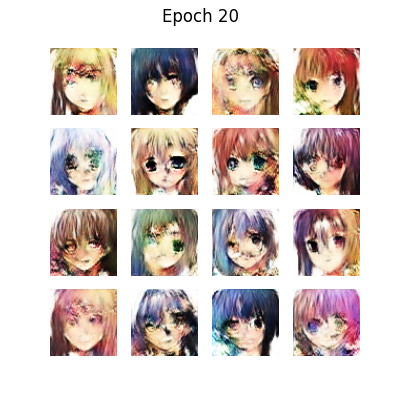

Epoch 20 | Gen loss: 1.2179 | Disc loss: 0.9533 | Time: 77.86s


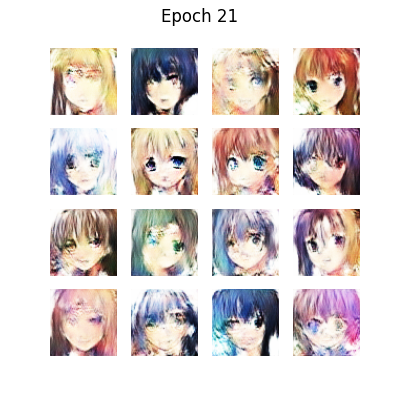

Epoch 21 | Gen loss: 1.2513 | Disc loss: 0.9224 | Time: 78.39s


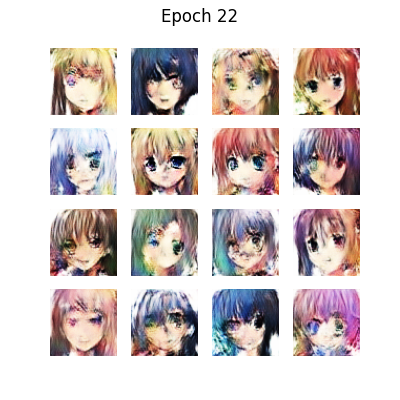

Epoch 22 | Gen loss: 1.3181 | Disc loss: 0.8771 | Time: 77.59s


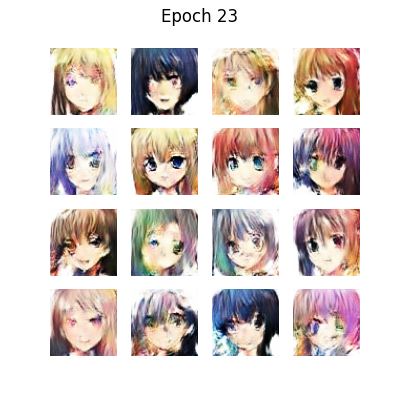

Epoch 23 | Gen loss: 1.3325 | Disc loss: 0.8922 | Time: 80.36s


In [ ]:
EPOCHS = 30
train(train_dataset, EPOCHS)

Download and prepare the anime face dataset.

Preprocess images and set up a TensorFlow data pipeline.

Define the generator and discriminator models for a DCGAN.

Implement loss functions and optimizers.

Set up training, checkpointing, and visualization.

Train the GAN and visualize progress after each epoch.
